In [29]:
import nltk
from textblob import TextBlob as tb
import math
import io
from __future__ import division
import numpy
import pandas as pd
import matplotlib
import nltk
import re
import os
import string
import codecs
from sklearn import feature_extraction
import mpld3
%matplotlib inline 

from sklearn.feature_extraction.text import TfidfVectorizer

os.chdir('/users/asheets/Documents/Work_Computer_new/Work_Computer/Grad_School/PREDICT_453/Notebooks/DSI/')

all_docs = []
dsis = []
d = 1

cachedStopWords = nltk.corpus.stopwords.words('english')
pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')

for i in range(40):
    doc_name = 'DSI' + str(d) + '.txt'
    try:
        with open(doc_name, 'r') as f:
            sample = f.read()
        sample = sample.decode('utf-8')
       #sample = sample.decode('ascii')
        sample = sample.lower()
        sample = re.sub(r'[^\w]', ' ', sample)
        sample = ''.join([i for i in sample if not i.isdigit()])
        sample = pattern.sub('', sample)
        sample = "".join(l for l in sample if l not in string.punctuation)
        sample2 = " ".join(k for k in tb(sample).noun_phrases)
        all_docs.append(sample)
        dsis.append('DSI' + str(d))
        d = d + 1
    except IOError:
        d = d + 1
        pass

titles = pd.read_table('document_titles.txt', sep='\t',header=None)
titles.columns =["DSI","Title"]

In [30]:
#Using resource: http://brandonrose.org/clustering
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [36]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in all_docs:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [42]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print("there are " + str(vocab_frame.shape[0]) + " items in vocab_frame")

there are 20391 items in vocab_frame


In [31]:

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(all_docs) #fit the vectorizer to all_docs

print(tfidf_matrix.shape)

CPU times: user 1.05 s, sys: 16.5 ms, total: 1.06 s
Wall time: 1.1 s
(38, 318)


In [32]:
terms = tfidf_vectorizer.get_feature_names()

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [34]:
#kmeans
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 123 ms, sys: 2.06 ms, total: 125 ms
Wall time: 125 ms


In [45]:
DSIs = { 'DSI': dsis, 'doc': all_docs, 'cluster': clusters }

frame = pd.DataFrame(DSIs, index = [clusters] , columns = ['DSI', 'cluster'])
#frame['cluster'].value_counts() 

clustering = pd.merge(titles, frame, on='DSI')
clustering = clustering.sort_values("cluster",ascending=True)
#clustering


In [46]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    #print("Cluster %d titles:" % i, end='')
    #for title in clustering.ix[i]['Title'].values.tolist():
    #    print(' %s,' % title, end='')
    #print() #add whitespace
    #print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: intelligence, elect, mr, democrats, vote, senate,

Cluster 1 words: wall, borders, mexico, construction, cost, report,

Cluster 2 words: energy, order, job, environmental, powered, regulation,

Cluster 3 words: trading, china, u, countries, states, national,

Cluster 4 words: tax, businesses, projects, spending, money, investments,





In [47]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'intelligence, elect, democrats, vote, senate', 
                 1: 'wall, borders, mexico, construction, cost, report', 
                 2: 'energy, order, job, environmental, powered, regulation', 
                 3: 'trading, china, countries, states, national', 
                 4: 'tax, businesses, projects, spending, money, investments'}

In [54]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


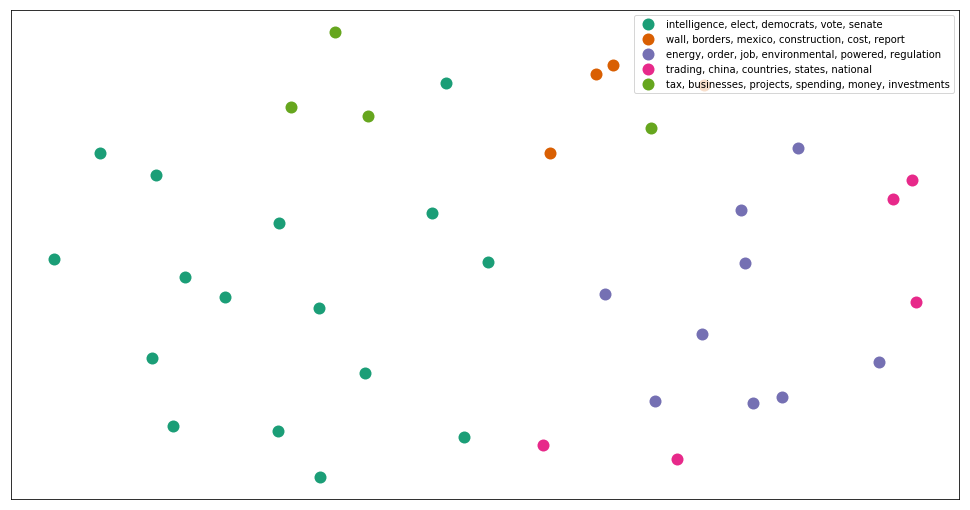

In [96]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

just_titles = clustering["Title"]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=just_titles)) 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [99]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 300);
      this.fig.toolbar.toolbar.attr("y", 600);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [100]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=just_titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=13, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in str(group.title).decode('utf-8')]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0],
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)